In [1]:
% matplotlib inline

from functools import reduce
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

#Pandas options
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 100)
pd.options.display.float_format = '{:,.2f}'.format

#Set seaborn plot theme
sns.set_style('darkgrid')

In [23]:
county_query = """
select *
from broadband.state_county
"""

In [65]:
fcc_query = """
SELECT state_county_code, AVG(max_down) AS down_speed
FROM broadband.fcc
GROUP BY state_county_code
"""

In [54]:
income_query = """
SELECT state_county_code, census_income_2016 AS income
FROM broadband.census_income
"""

In [55]:
housing_query = """
WITH geo AS (
  SELECT SUBSTR(block_code, 0, 5) AS state_county_code, AVG(land_area) AS area
  FROM broadband.geography
  GROUP BY state_county_code
)
SELECT 
    geo.state_county_code, 
    housing.total_housing_units2010census / geo.area AS housing_density
FROM broadband.census_housing housing
INNER JOIN geo ON housing.state_county_code = geo.state_county_code
"""

In [56]:
population_query = """
WITH geo AS (
  SELECT SUBSTR(block_code, 0, 5) AS state_county_code, AVG(land_area) AS area
  FROM broadband.geography
  GROUP BY state_county_code
)

SELECT 
    geo.state_county_code,
    population.census_population_2010 / geo.area AS population_density
FROM broadband.census_population population
INNER JOIN geo ON population.state_county_code = geo.state_county_code
"""

In [57]:
development_query = """
SELECT state_county_code, urban / (urban + rural) urban_ratio
FROM broadband.census_urban_rural_housing
"""

In [66]:
county = pd.read_gbq(county_query, project_id='fccdsicapstone-218522', dialect='standard')
fcc = pd.read_gbq(fcc_query, project_id='fccdsicapstone-218522', dialect='standard')

data = pd.merge(county, fcc, how='inner')

In [68]:
dfs = []

for query in [income_query, housing_query, population_query, development_query]:
    df = pd.read_gbq(query, project_id='fccdsicapstone-218522', dialect='standard')
    dfs.append(df)

attributes = reduce(lambda left, right: pd.merge(left, right, on='state_county_code', how='outer'), dfs)

In [69]:
data = pd.merge(data, attributes, how='left')

In [71]:
data.head()

,state_county_code,state,county,state_abbr,down_speed,income,housing_density,population_density,urban_ratio
0,19005,Iowa,Allamakee County,IA,55.39,"41,262.00",0.01,0.01,0.24
1,19007,Iowa,Appanoose County,IA,50.96,"36,236.00",0.01,0.02,0.42
2,19011,Iowa,Benton County,IA,61.07,"48,239.00",0.02,0.04,0.20
3,19013,Iowa,Black Hawk County,IA,130.84,"40,837.00",0.18,0.42,0.87
4,19015,Iowa,Boone County,IA,68.49,"44,926.00",0.02,0.05,0.52


In [72]:
data.describe()

,down_speed,income,housing_density,population_density,urban_ratio
count,"3,231.00","3,112.00","3,108.00","3,106.00","3,143.00"
mean,46.18,"40,768.07",0.35,0.90,0.40
std,40.83,"11,302.23",2.76,6.74,0.32
min,1.26,"16,267.00",0.00,0.00,0.00
25%,17.31,"33,923.75",0.01,0.01,0.11
50%,30.91,"38,604.00",0.02,0.04,0.39
75%,60.88,"45,004.75",0.06,0.15,0.66
max,227.93,"199,635.00",88.23,210.22,1.00


# Relationship of broadband speed and demographics

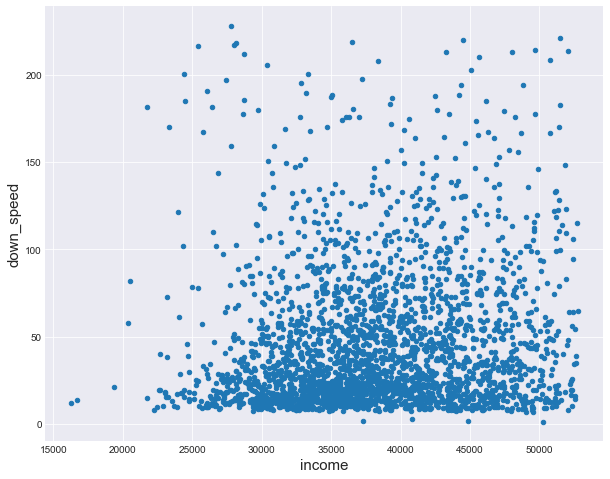

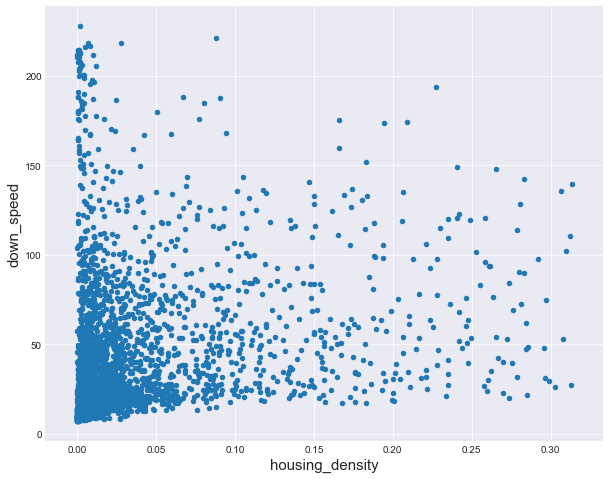

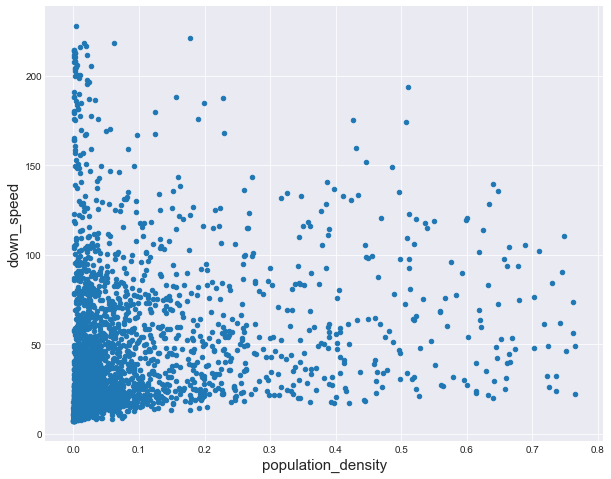

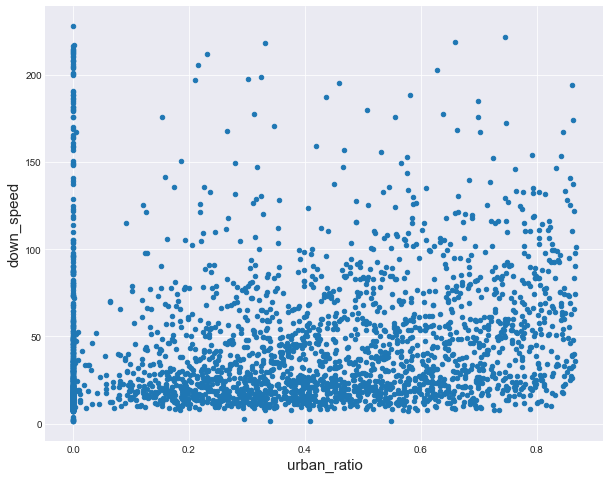

In [77]:
for x_col in data.columns[5:]:
    cutoff = data[x_col].quantile(0.9)
    subset = data[data[x_col] < cutoff]

    ax = subset.plot(kind='scatter', y='down_speed', x=x_col, figsize=(10, 8))
    ax.set_ylabel('down_speed', fontsize=15)
    ax.set_xlabel(x_col, fontsize=15)
    plt.show()